# Natural language processing - teaching notebook

## learning objectives
- become familiar with NLTK library in python
- Use NLTK library to tokenize text
- calculate sentiment scores for news articles using a bag-of-words approach
- plot time series of sentiment scores


In [1]:
!pip install nltk

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import string

import nltk
nltk.download('vader_lexicon')  # for sentiment analysis (scored list of words and jargon that NLTK references when performing sentiment analysis) 
# https://github.com/cjhutto/vaderSentiment
nltk.download('punkt')  # for tokenizing (data model that NLTK uses to split full texts into word lists)

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

sns.set_theme(style="whitegrid")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ben/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ben/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Let's get familiar with the nlkt library

`stopwords` are words that should be stopped at this step because they do not carry much information about the acutal meaning of the document

In [3]:
# here are some of the stop words in NLTK

sw = stopwords.words('english')
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [4]:
# punctuation characters from string library

pt = string.punctuation
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
# stem - reducing each word in all its forms to a root common to all its variants

stemmer = SnowballStemmer('english')

In [6]:
stemmer.stem('lovely') # Stem a word

'love'

In [7]:
lemma = WordNetLemmatizer()

In [8]:
lemma.lemmatize('tries')

'try'

In [9]:
# corpus from "Oh, the thinks you can think" by Dr. Seuss

docs = [
        'Oh, the thinks you can think if you only try.',
        'If you try, you can think up a guff going by.',
        'And what would you do if you met a jibboo?'
        ]

#### pipeline to transform documents into tokens (lowercase, tokenize, remove stopwords, punctuation, lemmatize)

In [10]:
def doc_to_tokens(doc):
    doc = doc.lower()
    doc = word_tokenize(doc) # split into single words
    doc = [token for token in doc if token not in sw and token not in pt]
    #doc = [stemmer.stem(token) for token in doc]
    doc = [lemma.lemmatize(token,"v") for token in doc]
    return doc

In [32]:
docs[0]

'Oh, the thinks you can think if you only try.'

In [11]:
# let's look at 0th sentence (document)
doc_to_tokens(docs[0])

['oh', 'think', 'think', 'try']

let's tokenize all the documents and use `set` to filter for unique tokens

In [12]:
vocabulary = set()
for doc in docs:
    for token in doc_to_tokens(doc):
        vocabulary.add(token)

print(vocabulary)

{'meet', 'go', 'would', 'guff', 'think', 'oh', 'jibboo', 'try'}


In [13]:
# words and frequency

vocabulary_lookup = {word: i for i, word in enumerate(vocabulary)}
vocabulary_lookup

{'meet': 0,
 'go': 1,
 'would': 2,
 'guff': 3,
 'think': 4,
 'oh': 5,
 'jibboo': 6,
 'try': 7}

### News Time Series Sentiment Analysis

Natural language processing (NLP) algorithms try to understand textual data. There are many techniques under the NLP umbrella including sentiment analysis.

News sentiment analysis is an important technique to gauge the public sentiment in a given span of time. In this example, we will work with time series news data to see how sentiment in a given category of news varies with time.

There are many important application of sentiment analysis such as speech recognition and language translation. Additional references: (Why do sentiment analysis?
https://hbr.org/2016/01/sentiment-analysis-can-do-more-than-prevent-fraud-and-turnover)

## load data

In [14]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [15]:
df.head(5)

category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3       Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4       Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   

                                   short_description       date  
0  She left her husband. He killed their children... 2018-05-26  
1                           Of course it has a song. 2018-05-26  
2  The actor and his longtime girlfriend Anna Ebe... 2018-05-26  
3  The actor gives Dems an ass-kicking for not fi... 2018-05-26  
4  The "Dietland" actress said using the bags is ... 2018-05-26

## Exploratory data analysis

Calculate number of articles published in each category of the dataset. List 5 most frequent categories

<AxesSubplot:>

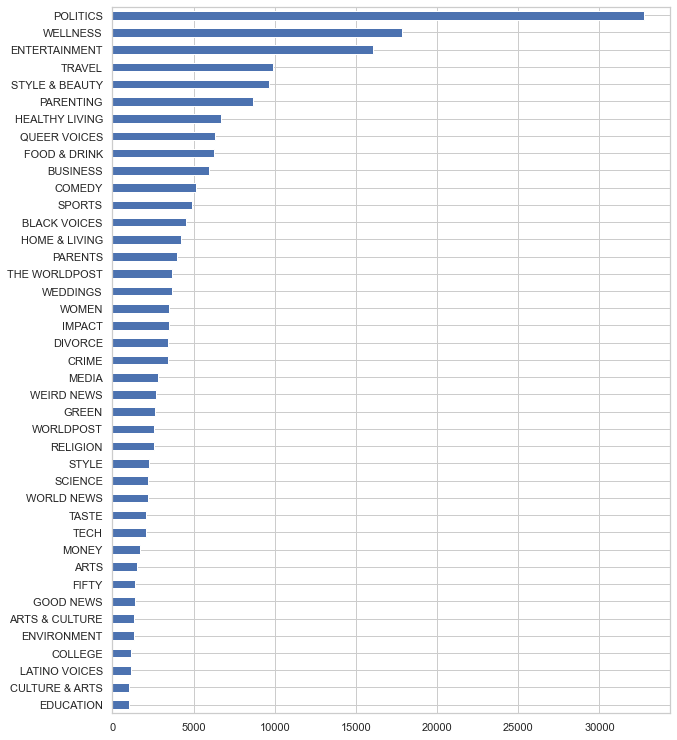

In [16]:
df.category.value_counts().sort_values().plot(kind = 'barh', figsize=(10,13))

In [17]:
df.dtypes

category                     object
headline                     object
authors                      object
link                         object
short_description            object
date                 datetime64[ns]
dtype: object

###  Pre-process the Data

In [18]:
# We will create dataframe containing data only from Education category
df_education = df[df['category'] == 'EDUCATION']

### Create a column `text_ip` as a combination of `headline` and `short_description`

In [19]:
df_education['text_ip'] = df_education['headline'] + " " + df_education['short_description']
df_education.head()

<ipython-input-19-75ac3a8b89c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_education['text_ip'] = df_education['headline'] + " " + df_education['short_description']


category                                           headline  \
443   EDUCATION  The Controversial Way Some California Schools ...   
1255  EDUCATION  California School First In The Nation To Be Di...   
1346  EDUCATION  States Are Favoring School Choice At A Steep C...   
1380  EDUCATION  Girls Reportedly Bleeding Through Pants Due To...   
1978  EDUCATION  Desperate For Teachers, Districts Beg Retirees...   

                                      authors  \
443               EdSource, Editorial Partner   
1255              EdSource, Editorial Partner   
1346   The Conversation US, Editorial Partner   
1380                              Doha Madani   
1978  The Hechinger Report, Editorial Partner   

                                                   link  \
443   https://www.huffingtonpost.com/entry/restorati...   
1255  https://www.huffingtonpost.com/entry/californi...   
1346  https://www.huffingtonpost.com/entry/states-ar...   
1380  https://www.huffingtonpost.com/entry/charter-s...   
1978  https://www.huffingtonpost.com/entry/teacher-s...   

                                      short_description       date  \
443   By David Washburn The two 9th-grade girls hear... 2018-05-17   
1255  By David Washburn Among the many disturbing tr... 2018-05-02   
1346  The current debate over school funding must mo... 2018-05-01   
1380  The school system is now allowing girls to tie... 2018-05-01   
1978  "It’s difficult not to respond when you hear t... 2018-04-19   

                                                text_ip  
443   The Controversial Way Some California Schools ...  
1255  California School First In The Nation To Be Di...  
1346  States Are Favoring School Choice At A Steep C...  
1380  Girls Reportedly Bleeding Through Pants Due To...  
1978  Desperate For Teachers, Districts Beg Retirees...

## Tokenize the text

Tokenization refers to splitting the text into words. NLTK allows us to do this quite easily using the word_tokenize method.

In [20]:
# first we'll get some sample text from the data
text_sample = df_education.iloc[202]['text_ip']
print(text_sample)

tokens = nltk.word_tokenize(text_sample)
tokens[:20]

Flipping The Switch What if boosting a toddler’s brainpower was as easy as turning on a light switch? In fact, “Flip the Switch” is one of the


['Flipping',
 'The',
 'Switch',
 'What',
 'if',
 'boosting',
 'a',
 'toddler',
 '’',
 's',
 'brainpower',
 'was',
 'as',
 'easy',
 'as',
 'turning',
 'on',
 'a',
 'light',
 'switch']

## How did sentiment in Education change with time?

### Use a NLTK's sentiment analyzer to determine sentiment score of `text` for every row

In [21]:
# We will use NLTK's Sentiment Intensity Analyzer which is based on a bag-of-words approach, 
# representing the text as an unordered collection of words
# It is a simple technique that disregards the sentence structure associated with the words

In [22]:
# here are some useful functions for our sentiment pipeline

def sentiment_pipeline(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)

def condition(score):
    if score > 0.2:
        return 'POSITIVE'
    elif score < -0.2:
        return 'NEGATIVE'
    else: 
        return 'NEUTRAL'

## Let's test our sentiment pipeline

In [23]:
text_example = df.iloc[1978]['headline']
print(text_example)
sentiment_pipeline(text_example)

Desperate For Teachers, Districts Beg Retirees To Come Back


{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'compound': -0.3182}

In [24]:
text_example = df.iloc[1982]['headline']
print(text_example)
sentiment_pipeline(text_example)

Adele Wrote About How Much She Loves Rihanna And, Honestly, Same


{'neg': 0.0, 'neu': 0.573, 'pos': 0.427, 'compound': 0.7717}

Compound score is a metric that has been normalized between -1(most extreme negative) and +1 (most extreme positive)

In [25]:
# let's run the text through the sentiment pipeline and add the label and sentiment score to the dataframe

df_education = (
    df_education
    .assign(sentiment = lambda x: x['text_ip'].apply(lambda s: sentiment_pipeline(s)))
    .assign(
         score = lambda x: x['sentiment'].apply(lambda s: (s['compound'])),
        label = lambda x: x['sentiment'].apply(lambda s: condition(s['compound']))
        
    )
)
df_education.head()

category                                           headline  \
443   EDUCATION  The Controversial Way Some California Schools ...   
1255  EDUCATION  California School First In The Nation To Be Di...   
1346  EDUCATION  States Are Favoring School Choice At A Steep C...   
1380  EDUCATION  Girls Reportedly Bleeding Through Pants Due To...   
1978  EDUCATION  Desperate For Teachers, Districts Beg Retirees...   

                                      authors  \
443               EdSource, Editorial Partner   
1255              EdSource, Editorial Partner   
1346   The Conversation US, Editorial Partner   
1380                              Doha Madani   
1978  The Hechinger Report, Editorial Partner   

                                                   link  \
443   https://www.huffingtonpost.com/entry/restorati...   
1255  https://www.huffingtonpost.com/entry/californi...   
1346  https://www.huffingtonpost.com/entry/states-ar...   
1380  https://www.huffingtonpost.com/entry/charter-s...   
1978  https://www.huffingtonpost.com/entry/teacher-s...   

                                      short_description       date  \
443   By David Washburn The two 9th-grade girls hear... 2018-05-17   
1255  By David Washburn Among the many disturbing tr... 2018-05-02   
1346  The current debate over school funding must mo... 2018-05-01   
1380  The school system is now allowing girls to tie... 2018-05-01   
1978  "It’s difficult not to respond when you hear t... 2018-04-19   

                                                text_ip  \
443   The Controversial Way Some California Schools ...   
1255  California School First In The Nation To Be Di...   
1346  States Are Favoring School Choice At A Steep C...   
1380  Girls Reportedly Bleeding Through Pants Due To...   
1978  Desperate For Teachers, Districts Beg Retirees...   

                                              sentiment   score     label  
443   {'neg': 0.055, 'neu': 0.848, 'pos': 0.097, 'co...  0.3400  POSITIVE  
1255  {'neg': 0.089, 'neu': 0.836, 'pos': 0.075, 'co... -0.1280   NEUTRAL  
1346  {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...  0.4215  POSITIVE  
1380  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  0.0000   NEUTRAL  
1978  {'neg': 0.187, 'neu': 0.742, 'pos': 0.07, 'com... -0.4588  NEGATIVE

In [26]:
df_education.dtypes

category                     object
headline                     object
authors                      object
link                         object
short_description            object
date                 datetime64[ns]
text_ip                      object
sentiment                    object
score                       float64
label                        object
dtype: object

### Calculate frequency of positive and negative labeled datapoints

<AxesSubplot:>

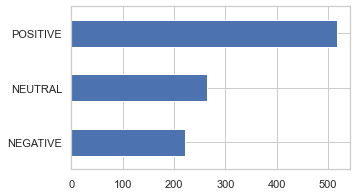

In [27]:
df_education.label.value_counts().sort_values().plot(kind = 'barh', figsize=(5,3))

### How did average sentiment score for positive and negative labelled articles in Education change with time?

In [28]:
# in order to make a time series plot of sentiment, let's make a new dataframe containing 
# the mean positive and negative sentiment on a given day between 2014-2019

tmp_df = []
for year in range(2014, 2019):
    for month in range(1, 13):
        x = df_education[(df_education['date'].dt.year == year) & (df_education['date'].dt.month == month)]['label'].value_counts().to_dict()


        tmp1 = {
        'Date': datetime.datetime(year, month, 28),
        'Frequency of Articles': 0,
        'Score': 0.0,
        'Sentiment': 'Positive'
    }

        tmp2 = {
        'Date': datetime.datetime(year, month, 28),
        'Frequency of Articles': 0,
        'Score': 0.0,
        'Sentiment': 'Negative'
    }

        if 'POSITIVE' in x:
            tmp1['Frequency of Articles'] = x['POSITIVE']
        if 'NEGATIVE' in x:
            tmp2['Frequency of Articles'] = x['NEGATIVE']
        if tmp1['Frequency of Articles'] == 0 and tmp2['Frequency of Articles'] == 0:
            continue

        y = df_education[(df_education['date'].dt.year == year) & (df_education['date'].dt.month == month)][['label', 'score']]
 
        tmp1['Score'] = y[y['label'] == 'POSITIVE']['score'].mean()
        tmp2['Score'] = y[y['label'] == 'NEGATIVE']['score'].mean() 
    
        tmp_df.append(tmp1)
        tmp_df.append(tmp2)



mod_df = pd.DataFrame(tmp_df)


In [29]:
mod_df.head()

Date  Frequency of Articles     Score Sentiment
0 2014-04-28                      8  0.578987  Positive
1 2014-04-28                      4 -0.564775  Negative
2 2014-05-28                     29  0.607414  Positive
3 2014-05-28                      5 -0.573720  Negative
4 2014-06-28                     13  0.548708  Positive

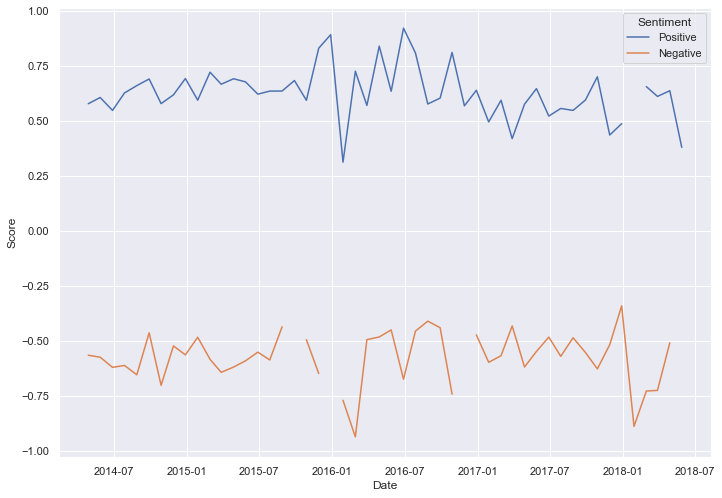

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=mod_df, x="Date", y="Score", hue="Sentiment");

In [33]:
# At the beginning of 2016, we can see a dip in sentiment scores in this time series plot.

# Generally speaking, NLTK's bag-of-words approach to sentiment analysis lacks the ability to understand word context.
# Other approaches such as those based on transformers can understand word context 
# and can more accurately analyze sentiment.